# Exploratory Data Analysis
    
The goal of this competition is to use seismic signals to predict the timing of laboratory earthquakes. The data comes from a well-known experimental set-up used to study earthquake physics.

- The **training data** is a single, continuous segment of experimental data. 
- The **test data** consists of a folder containing many small segments. The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment; thus, the predictions cannot be assumed to follow the same regular pattern seen in the training file.

For each *seg_id* in the test folder, you should predict a single *time_to_failure* corresponding to the time between the last row of the segment and the next laboratory earthquake.

[Scores](https://docs.google.com/spreadsheets/d/1AWLPZfryFWx6wM9fxmMmGm31R4B9PMrZzLp71ZtlcRk/edit#gid=0)

In [1]:
# Convenience
import gc
import warnings
from tqdm import tqdm
from tqdm import tqdm_notebook

import random
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Machine Learning libraries
import xgboost as xgb
import lightgbm as lgb
from sklearn import linear_model
from sklearn import model_selection
from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error, roc_curve, auc

# Signal processing
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge

# Keras
from keras.models import Sequential
from keras.layers import Dense, CuDNNGRU
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint

warnings.filterwarnings("ignore")

random.seed(1)

pd.options.display.precision = 15
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500
pd.options.display.width = 1000

In [2]:
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

[Earthquakes FE. More features and samples](https://www.kaggle.com/artgor/earthquakes-fe-more-features-and-samples)<br/>
[Seismic data EDA and baseline](https://www.kaggle.com/artgor/seismic-data-eda-and-baseline)<br/>
[Shaking Earth](https://www.kaggle.com/allunia/shaking-earth)

## Loading data

In [7]:
df_train = pd.read_csv('input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
df_train = reduce_memory_usage(df_train)
print("{:,} records and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))

Starting memory usage: 3600.00 MB
Reduced memory usage: 2400.00 MB (33.3% reduction)
629,145,480 records and 2 features in train set.


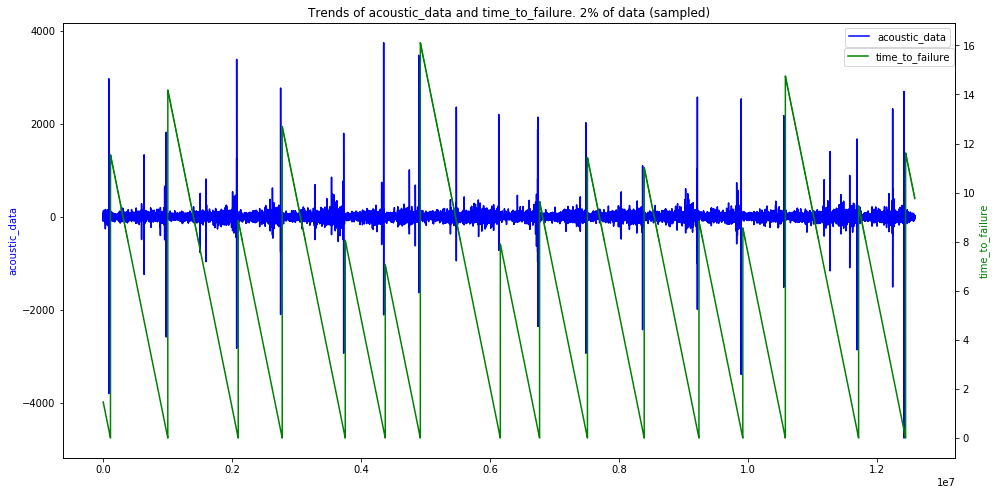

In [4]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
plt.plot(df_train['acoustic_data'].values[::50], color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(df_train['time_to_failure'].values[::50], color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

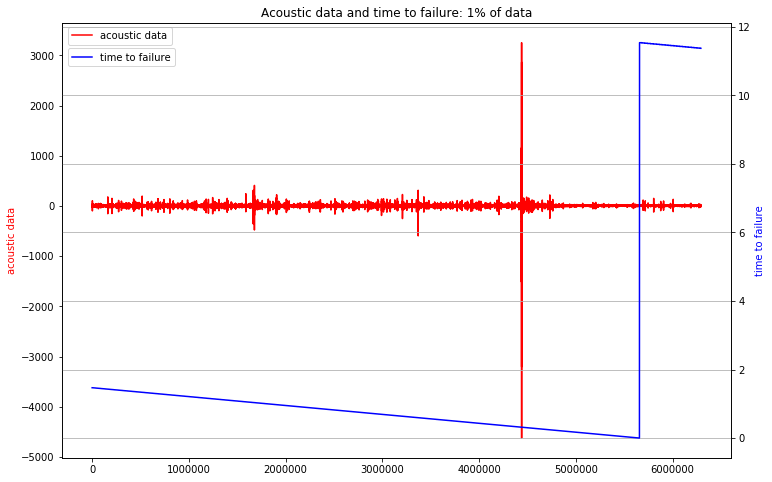

In [7]:
fig, ax1 = plt.subplots(figsize=(12, 8))
plt.title("Acoustic data and time to failure: 1% of data")
plt.plot(df_train['acoustic_data'].values[:6291455], color='r')
ax1.set_ylabel('acoustic data', color='r')
plt.legend(['acoustic data'], loc=(0.01, 0.95))

ax2 = ax1.twinx()
plt.plot(df_train['time_to_failure'].values[:6291455], color='b')
ax2.set_ylabel('time to failure', color='b')
plt.legend(['time to failure'], loc=(0.01, 0.9))
plt.grid(True)

## Feature engineering
Inspired by [Andrews Script plus a Genetic Program Model](https://www.kaggle.com/scirpus/andrews-script-plus-a-genetic-program-model)<br/>
[Understanding and parameter setting of STA/LTA trigger
algorithm](http://gfzpublic.gfz-potsdam.de/pubman/item/escidoc:4097:3/component/escidoc:4098/IS_8.1_rev1.pdf)

In [8]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

In [15]:
rows = 150_000
segments = int(np.floor(df_train.shape[0] / rows))
print('Number of segments: {:,}'.format(segments))

X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)
y_tr = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

print('Calculating mean')
total_mean = df_train['acoustic_data'].mean()
print('Calculating standard deviation')
total_std = df_train['acoustic_data'].std()
print('Finding maximum')
total_max = df_train['acoustic_data'].max()
print('Finding minimum')
total_min = df_train['acoustic_data'].min()
print('Calculating sum')
total_sum = df_train['acoustic_data'].sum()
print('Calculating absolute value of sum')
total_abs_sum = np.abs(df_train['acoustic_data']).sum()

for segment in tqdm_notebook(range(segments)):
    seg = df_train.iloc[segment*rows:segment*rows+rows]
    x = pd.Series(seg['acoustic_data'].values)
    y = seg['time_to_failure'].values[-1]
    
    y_tr.loc[segment, 'time_to_failure'] = y
    X_tr.loc[segment, 'mean'] = x.mean()
    X_tr.loc[segment, 'std'] = x.std()
    X_tr.loc[segment, 'max'] = x.max()
    X_tr.loc[segment, 'min'] = x.min()
    
    
    X_tr.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
    X_tr.loc[segment, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    X_tr.loc[segment, 'abs_max'] = np.abs(x).max()
    X_tr.loc[segment, 'abs_min'] = np.abs(x).min()
    
    X_tr.loc[segment, 'std_first_50000'] = x[:50000].std()
    X_tr.loc[segment, 'std_last_50000'] = x[-50000:].std()
    X_tr.loc[segment, 'std_first_10000'] = x[:10000].std()
    X_tr.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
    X_tr.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    X_tr.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    X_tr.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    X_tr.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
    X_tr.loc[segment, 'min_first_50000'] = x[:50000].min()
    X_tr.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X_tr.loc[segment, 'min_first_10000'] = x[:10000].min()
    X_tr.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
    X_tr.loc[segment, 'max_first_50000'] = x[:50000].max()
    X_tr.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X_tr.loc[segment, 'max_first_10000'] = x[:10000].max()
    X_tr.loc[segment, 'max_last_10000'] = x[-10000:].max()
    
    X_tr.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    X_tr.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_tr.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])
    X_tr.loc[segment, 'sum'] = x.sum()
    
    X_tr.loc[segment, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(x[:50000]) / x[:50000][:-1]))[0])
    X_tr.loc[segment, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(x[-50000:]) / x[-50000:][:-1]))[0])
    X_tr.loc[segment, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(x[:10000]) / x[:10000][:-1]))[0])
    X_tr.loc[segment, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(x[-10000:]) / x[-10000:][:-1]))[0])
    
    X_tr.loc[segment, 'q95'] = np.quantile(x, 0.95)
    X_tr.loc[segment, 'q99'] = np.quantile(x, 0.99)
    X_tr.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X_tr.loc[segment, 'q01'] = np.quantile(x, 0.01)
    
    X_tr.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_tr.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_tr.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_tr.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_tr.loc[segment, 'trend'] = add_trend_feature(x)
    X_tr.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_tr.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_tr.loc[segment, 'abs_std'] = np.abs(x).std()
    
    X_tr.loc[segment, 'mad'] = x.mad()
    X_tr.loc[segment, 'kurt'] = x.kurtosis()
    X_tr.loc[segment, 'skew'] = x.skew()
    X_tr.loc[segment, 'med'] = x.median()
    
    X_tr.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_tr.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_tr.loc[segment, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_tr.loc[segment, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_tr.loc[segment, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_tr.loc[segment, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_tr.loc[segment, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    X_tr.loc[segment, 'Moving_average_1500_mean'] = x.rolling(window=1500).mean().mean(skipna=True)
    X_tr.loc[segment, 'Moving_average_3000_mean'] = x.rolling(window=3000).mean().mean(skipna=True)
    X_tr.loc[segment, 'Moving_average_6000_mean'] = x.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_tr.loc[segment, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_30000_mean'] = ewma(x, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X_tr.loc[segment, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_tr.loc[segment,'MA_700MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment,'MA_700MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_tr.loc[segment,'MA_400MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment,'MA_400MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    
    X_tr.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_tr.loc[segment, 'q999'] = np.quantile(x, 0.999)
    X_tr.loc[segment, 'q001'] = np.quantile(x, 0.001)
    X_tr.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_tr.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_tr.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_tr.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_tr.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_tr.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_tr.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_tr.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_tr.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_tr.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_tr.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_tr.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_tr.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_tr.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_tr.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_tr.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_tr.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_tr.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_tr.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

Number of segments: 4,194
Calculating mean
Calculating standard deviation
Finding maximum
Finding minimum
Calculating sum
Calculating absolute value of sum


In [6]:
print('{:,} samples in new train data and {:,} columns.'.format(X_tr.shape[0], X_tr.shape[1]))

4,194 samples in new train data and 138 columns.


In [17]:
X_tr_all = pd.concat([X_tr, y_tr], axis=1)

In [18]:
X_tr_all[:5]

,mean,std,max,min,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,std_first_10000,std_last_10000,avg_first_50000,avg_last_50000,avg_first_10000,avg_last_10000,min_first_50000,min_last_50000,min_first_10000,min_last_10000,max_first_50000,max_last_50000,max_first_10000,max_last_10000,max_to_min,max_to_min_diff,count_big,sum,mean_change_rate_first_50000,mean_change_rate_last_50000,mean_change_rate_first_10000,mean_change_rate_last_10000,q95,q99,q05,q01,abs_q95,abs_q99,abs_q05,abs_q01,trend,abs_trend,abs_mean,abs_std,mad,kurt,skew,med,Hilbert_mean,Hann_window_mean,classic_sta_lta1_mean,classic_sta_lta2_mean,classic_sta_lta3_mean,classic_sta_lta4_mean,Moving_average_700_mean,Moving_average_1500_mean,Moving_average_3000_mean,Moving_average_6000_mean,exp_Moving_average_300_mean,exp_Moving_average_3000_mean,exp_Moving_average_30000_mean,MA_700MA_std_mean,MA_700MA_BB_high_mean,MA_700MA_BB_low_mean,MA_400MA_std_mean,MA_400MA_BB_high_mean,MA_400MA_BB_low_mean,MA_1000MA_std_mean,iqr,q999,q001,ave10,ave_roll_std_10,std_roll_std_10,max_roll_std_10,min_roll_std_10,q01_roll_std_10,q05_roll_std_10,q95_roll_std_10,q99_roll_std_10,av_change_abs_roll_std_10,av_change_rate_roll_std_10,abs_max_roll_std_10,ave_roll_mean_10,std_roll_mean_10,max_roll_mean_10,min_roll_mean_10,q01_roll_mean_10,q05_roll_mean_10,q95_roll_mean_10,q99_roll_mean_10,av_change_abs_roll_mean_10,av_change_rate_roll_mean_10,abs_max_roll_mean_10,ave_roll_std_100,std_roll_std_100,max_roll_std_100,min_roll_std_100,q01_roll_std_100,q05_roll_std_100,q95_roll_std_100,q99_roll_std_100,av_change_abs_roll_std_100,av_change_rate_roll_std_100,abs_max_roll_std_100,ave_roll_mean_100,std_roll_mean_100,max_roll_mean_100,min_roll_mean_100,q01_roll_mean_100,q05_roll_mean_100,q95_roll_mean_100,q99_roll_mean_100,av_change_abs_roll_mean_100,av_change_rate_roll_mean_100,abs_max_roll_mean_100,ave_roll_std_1000,std_roll_std_1000,max_roll_std_1000,min_roll_std_1000,q01_roll_std_1000,q05_roll_std_1000,q95_roll_std_1000,q99_roll_std_1000,av_change_abs_roll_std_1000,av_change_rate_roll_std_1000,abs_max_roll_std_1000,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000,time_to_failure
0,4.884113333333334,5.101106130606765,104.0,-98.0,-0.000080000533337,74836.577199220613693,104.0,0.0,6.488551888989741,3.664663420228340,11.207151110947080,4.361406519310332,4.96210,4.62046,5.1820,4.6756,-98.0,-21.0,-98.0,-16.0,104.0,30.0,104.0,26.0,1.061224460601807,6.0,0.0,732617.0,24942.324635647688410,25002.266464332984469,4981.149551569506912,4983.576120424221699,11.0,18.0,-2.0,-8.0,12.0,20.0,1.0,0.0,-0.000003268299817,-0.000011278536937,5.576566666666666,4.333324673993449,3.263401356800000,33.662481293451094,-0.024061166628209,5.0,7.027028035412705,4.883327023570954,0.920976028914028,0.266087336023126,0.935910825361665,0.808124398212053,4.883593057935697,4.882672085260930,4.880503078210353,4.877772253896385,4.884650448524550,4.887354492458108,4.891813589971528,4.229416497006206,13.342426051948108,-3.575239936076715,4.155806235470028,13.195205528875753,-3.428019413004360,4.288590310584311,4.0,40.00000000000000,-30.0,4.869341666666666,3.507117717076894,2.809071196343532,78.313047018573698,0.421637021355338,1.264911064067210,1.636391694484328,7.226494462892889,15.034220133197675,-0.000001534223484,74731.047121098483331,78.313047018573698,4.884088378636050,2.801800226146299,68.500000000000000,-60.000000000000000,-2.400000000000000,1.7,8.100000000000000,12.400000000000000,-0.000011334088939,74736.692043168892269,68.500000000000000,4.050449943320652,3.111524285420867,52.335254741797996,1.935422069177468,2.302633538390867,2.475638882952861,8.195903140156636,16.948796924021416,-0.000005235445272,74759.569448178153834,52.335254741797996,4.883863549942963,0.452293846429352,10.039999999999999,1.040000000000000,3.81,4.16,5.

In [22]:
X_tr_all = reduce_memory_usage(X_tr_all)

del df_train
gc.collect()

Starting memory usage:  1.18 MB
Reduced memory usage:  1.18 MB (0.0% reduction)


228

In [20]:
X_tr_all.to_csv('preprocessed/segment_features_train_150k.csv')

In [16]:
np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(10)

q05_roll_std_100     0.648817801927166
q01_roll_std_100     0.644823675208764
q05_roll_std_10      0.643260059679872
q01_roll_std_10      0.635609997513731
q05_roll_std_1000    0.614520140222605
q01_roll_std_1000    0.603712245760335
min_roll_std_1000    0.544284771537155
iqr                  0.506998596380168
q95_roll_std_10      0.439749865990360
q95_roll_mean_10     0.439477403868452
dtype: float64

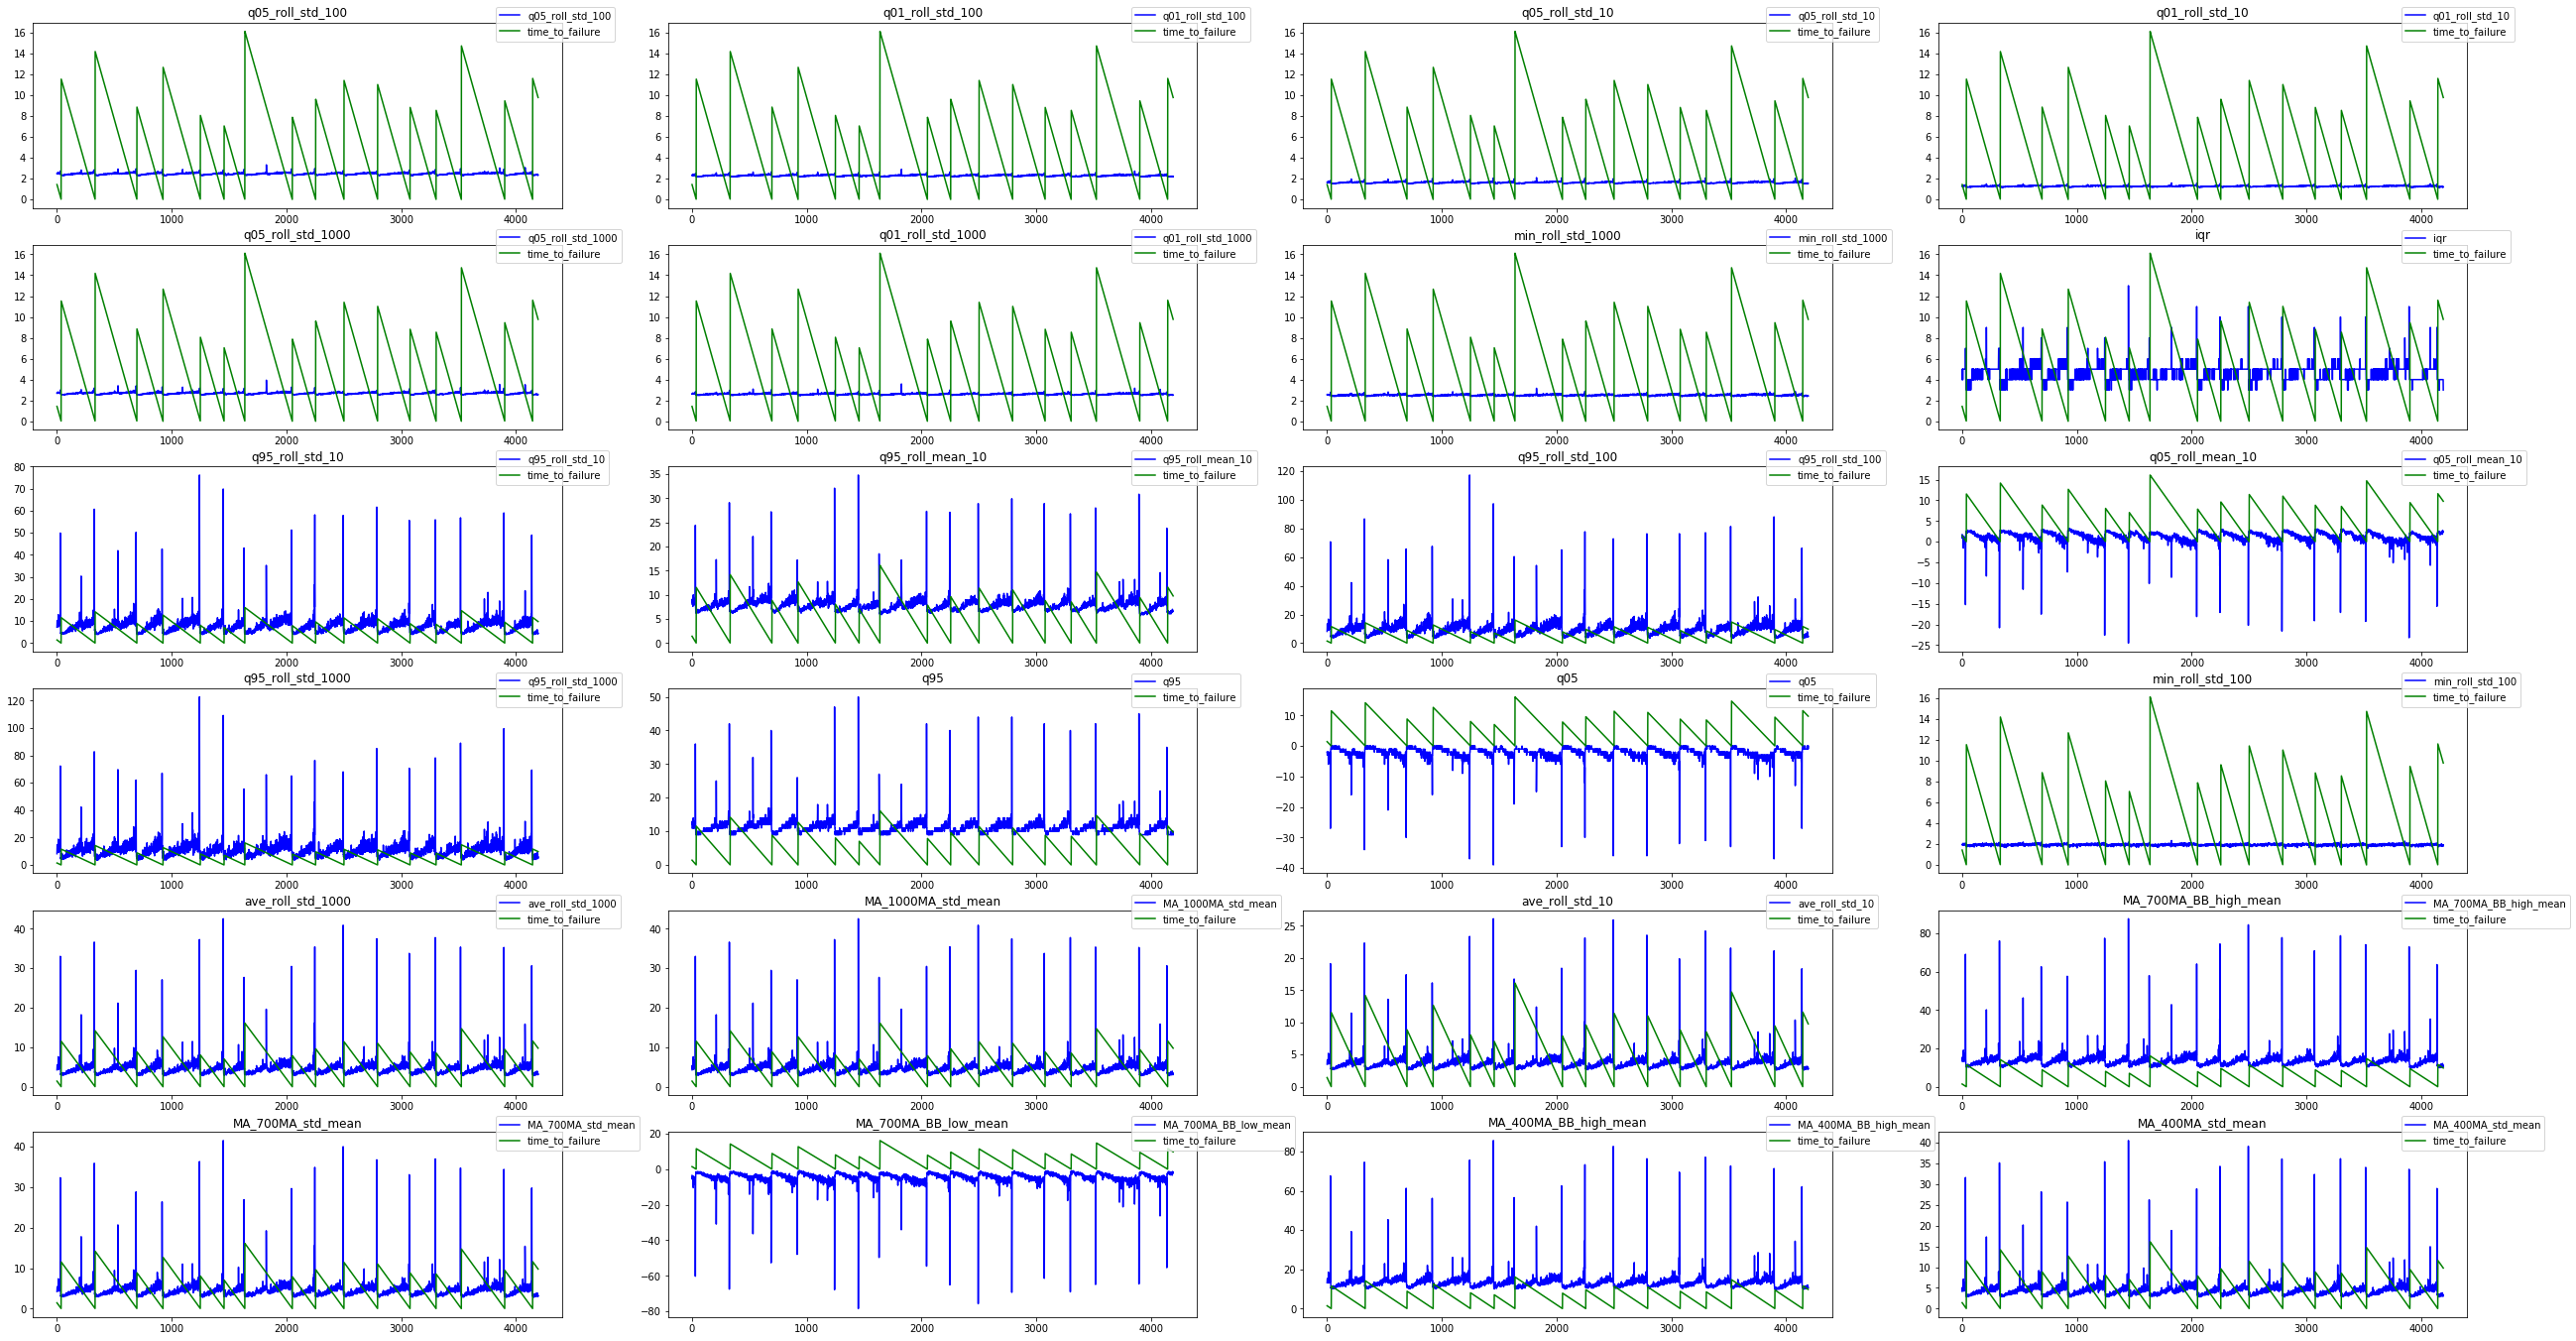

In [17]:
plt.figure(figsize=(44, 24))
cols = list(np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(24).index)
for i, col in enumerate(cols):
    plt.subplot(6, 4, i + 1)
    plt.plot(X_tr[col], color='blue')
    plt.title(col)
    ax1.set_ylabel(col, color='b')

    ax2 = ax1.twinx()
    plt.plot(y_tr, color='g')
    ax2.set_ylabel('time_to_failure', color='g')
    plt.legend([col, 'time_to_failure'], loc=(0.875, 0.9))
    plt.grid(False)

In [ ]:
submission = pd.read_csv('input/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)

for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv('input/test/' + seg_id + '.csv')
    
    x = pd.Series(seg['acoustic_data'].values)
    X_test.loc[seg_id, 'mean'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
        
    X_test.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(x))
    X_test.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    X_test.loc[seg_id, 'abs_max'] = np.abs(x).max()
    X_test.loc[seg_id, 'abs_min'] = np.abs(x).min()
    
    X_test.loc[seg_id, 'std_first_50000'] = x[:50000].std()
    X_test.loc[seg_id, 'std_last_50000'] = x[-50000:].std()
    X_test.loc[seg_id, 'std_first_10000'] = x[:10000].std()
    X_test.loc[seg_id, 'std_last_10000'] = x[-10000:].std()
    
    X_test.loc[seg_id, 'avg_first_50000'] = x[:50000].mean()
    X_test.loc[seg_id, 'avg_last_50000'] = x[-50000:].mean()
    X_test.loc[seg_id, 'avg_first_10000'] = x[:10000].mean()
    X_test.loc[seg_id, 'avg_last_10000'] = x[-10000:].mean()
    
    X_test.loc[seg_id, 'min_first_50000'] = x[:50000].min()
    X_test.loc[seg_id, 'min_last_50000'] = x[-50000:].min()
    X_test.loc[seg_id, 'min_first_10000'] = x[:10000].min()
    X_test.loc[seg_id, 'min_last_10000'] = x[-10000:].min()
    
    X_test.loc[seg_id, 'max_first_50000'] = x[:50000].max()
    X_test.loc[seg_id, 'max_last_50000'] = x[-50000:].max()
    X_test.loc[seg_id, 'max_first_10000'] = x[:10000].max()
    X_test.loc[seg_id, 'max_last_10000'] = x[-10000:].max()
    
    X_test.loc[seg_id, 'max_to_min'] = x.max() / np.abs(x.min())
    X_test.loc[seg_id, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_test.loc[seg_id, 'count_big'] = len(x[np.abs(x) > 500])
    X_test.loc[seg_id, 'sum'] = x.sum()
    
    X_test.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(x[:50000]) / x[:50000][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(x[-50000:]) / x[-50000:][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(x[:10000]) / x[:10000][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(x[-10000:]) / x[-10000:][:-1]))[0])
    
    X_test.loc[seg_id, 'q95'] = np.quantile(x,0.95)
    X_test.loc[seg_id, 'q99'] = np.quantile(x,0.99)
    X_test.loc[seg_id, 'q05'] = np.quantile(x,0.05)
    X_test.loc[seg_id, 'q01'] = np.quantile(x,0.01)
    
    X_test.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_test.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_test.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_test.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_test.loc[seg_id, 'trend'] = add_trend_feature(x)
    X_test.loc[seg_id, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_test.loc[seg_id, 'abs_mean'] = np.abs(x).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(x).std()
    
    X_test.loc[seg_id, 'mad'] = x.mad()
    X_test.loc[seg_id, 'kurt'] = x.kurtosis()
    X_test.loc[seg_id, 'skew'] = x.skew()
    X_test.loc[seg_id, 'med'] = x.median()
    
    X_test.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_test.loc[seg_id, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_test.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_test.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_test.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_test.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_test.loc[seg_id, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_average_1500_mean'] = x.rolling(window=1500).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_average_3000_mean'] = x.rolling(window=3000).mean().mean(skipna=True)
    X_test.loc[seg_id, 'Moving_average_6000_mean'] = x.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_test.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(x, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X_test.loc[seg_id, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_test.loc[seg_id,'MA_700MA_BB_high_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X_test.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X_test.loc[seg_id,'MA_700MA_BB_low_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X_test.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X_test.loc[seg_id, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_test.loc[seg_id,'MA_400MA_BB_high_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X_test.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X_test.loc[seg_id,'MA_400MA_BB_low_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X_test.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X_test.loc[seg_id, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    
    X_test.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_test.loc[seg_id, 'q999'] = np.quantile(x,0.999)
    X_test.loc[seg_id, 'q001'] = np.quantile(x,0.001)
    X_test.loc[seg_id, 'ave10'] = stats.trim_mean(x, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_test.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_test.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_test.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_test.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_test.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_test.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_test.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_test.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_test.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_test.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_test.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_test.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [20]:
X_test.to_csv('preprocessed/segment_features_test_150k.csv')

### Load features

In [6]:
X_tr = pd.read_csv('preprocessed/segment_features_train_150k.csv', index_col=0)
X_tr = reduce_memory_usage(X_tr)
print("{:,} records and {} features in train set.".format(X_tr.shape[0], X_tr.shape[1]))

Starting memory usage:  4.48 MB
Reduced memory usage:  1.21 MB (73.0% reduction)
4,194 records and 139 features in train set.


In [41]:
X_test = pd.read_csv('preprocessed/segment_features_test_150k.csv', index_col=0)
X_test = reduce_memory_usage(X_test)
print("{:,} records and {} features in train set.".format(X_test.shape[0], X_test.shape[1]))

Starting memory usage:  2.78 MB
Reduced memory usage:  0.75 MB (73.0% reduction)
2,624 records and 138 features in train set.


## Feature selection

## Training

In [11]:
X_tr[:5]

,mean,std,max,min,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,std_first_10000,std_last_10000,avg_first_50000,avg_last_50000,avg_first_10000,avg_last_10000,min_first_50000,min_last_50000,min_first_10000,min_last_10000,max_first_50000,max_last_50000,max_first_10000,max_last_10000,max_to_min,max_to_min_diff,count_big,sum,mean_change_rate_first_50000,mean_change_rate_last_50000,mean_change_rate_first_10000,mean_change_rate_last_10000,q95,q99,q05,q01,abs_q95,abs_q99,abs_q05,abs_q01,trend,abs_trend,abs_mean,abs_std,mad,kurt,skew,med,Hilbert_mean,Hann_window_mean,classic_sta_lta1_mean,classic_sta_lta2_mean,classic_sta_lta3_mean,classic_sta_lta4_mean,Moving_average_700_mean,Moving_average_1500_mean,Moving_average_3000_mean,Moving_average_6000_mean,exp_Moving_average_300_mean,exp_Moving_average_3000_mean,exp_Moving_average_30000_mean,MA_700MA_std_mean,MA_700MA_BB_high_mean,MA_700MA_BB_low_mean,MA_400MA_std_mean,MA_400MA_BB_high_mean,MA_400MA_BB_low_mean,MA_1000MA_std_mean,iqr,q999,q001,ave10,ave_roll_std_10,std_roll_std_10,max_roll_std_10,min_roll_std_10,q01_roll_std_10,q05_roll_std_10,q95_roll_std_10,q99_roll_std_10,av_change_abs_roll_std_10,av_change_rate_roll_std_10,abs_max_roll_std_10,ave_roll_mean_10,std_roll_mean_10,max_roll_mean_10,min_roll_mean_10,q01_roll_mean_10,q05_roll_mean_10,q95_roll_mean_10,q99_roll_mean_10,av_change_abs_roll_mean_10,av_change_rate_roll_mean_10,abs_max_roll_mean_10,ave_roll_std_100,std_roll_std_100,max_roll_std_100,min_roll_std_100,q01_roll_std_100,q05_roll_std_100,q95_roll_std_100,q99_roll_std_100,av_change_abs_roll_std_100,av_change_rate_roll_std_100,abs_max_roll_std_100,ave_roll_mean_100,std_roll_mean_100,max_roll_mean_100,min_roll_mean_100,q01_roll_mean_100,q05_roll_mean_100,q95_roll_mean_100,q99_roll_mean_100,av_change_abs_roll_mean_100,av_change_rate_roll_mean_100,abs_max_roll_mean_100,ave_roll_std_1000,std_roll_std_1000,max_roll_std_1000,min_roll_std_1000,q01_roll_std_1000,q05_roll_std_1000,q95_roll_std_1000,q99_roll_std_1000,av_change_abs_roll_std_1000,av_change_rate_roll_std_1000,abs_max_roll_std_1000,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000,time_to_failure
0,4.88281250,5.10156250,104.0,-98.0,-0.000079989433289,74836.5781250,104.0,0.0,6.48828125,3.66406250,11.2109375,4.36328125,4.96093750,4.62109375,5.18359375,4.67578125,-98.0,-21.0,-98.0,-16.0,104.0,30.0,104.0,26.0,1.06152343750,6.0,0.0,732617.0,24944.0,25008.0,4980.0,4984.0,11.0,18.0,-2.0,-8.0,12.0,20.0,1.0,0.0,-0.000003278255463,-0.000011265277863,5.57812500,4.33203125,3.263671875,33.65625,-0.024063110351562,5.0,7.02734375,4.88281250,0.92089843750,0.266113281250,0.93603515625,0.80810546875,4.88281250,4.88281250,4.87890625,4.87890625,4.88281250,4.88671875,4.89062500,4.23046875,13.3437500,-3.576171875,4.15625000,13.1953125,-3.427734375,4.28906250,4.0,40.0,-30.0,4.87109375,3.50781250,2.80859375,78.3125,0.421630859375,1.2646484375,1.6367187500,7.2265625,15.031250,-0.000001549720764,74731.0468750,78.3125,4.88281250,2.802734375,68.5000,-60.000,-2.400390625,1.7001953125,8.1015625,12.3984375,-0.000011324882507,74736.6953125,68.5000,4.05078125,3.111328125,52.34375,1.9355468750,2.302734375,2.47656250,8.1953125,16.953125,-0.000005245208740,74759.5703125,52.34375,4.88281250,0.452392578125,10.0390625,1.0400390625,3.810546875,4.16015625,5.57812500,5.94921875,-0.000002384185791,74760.0546875,10.0390625,4.28906250,2.76953125,31.03125,2.537109375,2.615234375,2.707031250,8.187500,15.0546875,-0.000011801719666,74223.5781250,31.03125,4.88281250,0.2956542968750,5.62890625,3.896484375,4.07031250,4.37890625,5.33984375,5.48437500,-0.000001728534698,74222.3437500,5.62890625,1.4306640625
1,4.72656250,6.58984375,181.0,-154.0,0.000000000000000,74891.7343750,181.0,0.0,7.30468750,5.49218750,3.9765625,3.66796875,4.69921875,4.78906250,4.77734375,4.9

In [12]:
y_train = X_tr['time_to_failure']
X_train = X_tr.drop('time_to_failure', axis=1)

In [13]:
X_train.shape, y_train.shape

((4194, 138), (4194,))

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

### Machine Learning Algorithms

In [33]:
MLA = [
    # Linear models
    linear_model.LinearRegression(),
    linear_model.Ridge(),
    linear_model.Lasso(alpha=0.1),
    linear_model.ElasticNet(),
    linear_model.LassoLars(alpha=.1),
    linear_model.BayesianRidge(),
    linear_model.SGDRegressor(),
    linear_model.PassiveAggressiveRegressor(),
    linear_model.RANSACRegressor(),
    #linear_model.TheilSenRegressor(),
    linear_model.HuberRegressor(),

    # SVR
    NuSVR(),

    # LightGBM
    lgb.LGBMRegressor(learning_rate=0.05),
    
    # CatBoost
    CatBoostRegressor(iterations=5, loss_function='MAE', verbose=False)
]

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .25, train_size = .75, random_state = 0 )

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = X_train

#index through MLA and save performance to table
row_index = 0
for alg in MLA:
    #set name and parameters
    MLA_name = alg.__class__.__name__
    print(MLA_name)
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, X_train_scaled, y_train, cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!

    #save MLA predictions - see section 6 for usage
    alg.fit(X_train_scaled, y_train)
    MLA_predict[MLA_name] = alg.predict(X_train_scaled)

    row_index+=1
    
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)

LinearRegression
Ridge
Lasso
ElasticNet
LassoLars
BayesianRidge
SGDRegressor
PassiveAggressiveRegressor
RANSACRegressor
HuberRegressor
NuSVR
LGBMRegressor
CatBoostRegressor


In [34]:
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
12,CatBoostRegressor,"{'verbose': False, 'loss_function': 'MAE', 'it...",6.73236054686568,6.62181247025828,0.289761172035644,0.403638672828674
10,NuSVR,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...",0.499195085172468,0.468674364699503,0.0539267977588304,1.69892685413361
11,LGBMRegressor,"{'boosting_type': 'gbdt', 'class_weight': None...",0.785539679295323,0.451771627591811,0.0643623111155235,1.32035617828369
5,BayesianRidge,"{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_...",0.452871790483159,0.429057354606119,0.0584653153537752,0.0478315114974976
2,Lasso,"{'alpha': 0.1, 'copy_X': True, 'fit_intercept'...",0.437007270101535,0.426709106987607,0.0553007429645259,0.204353904724121
1,Ridge,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.475730741994194,0.408496803760748,0.0725590527403893,0.0133987665176392
9,HuberRegressor,"{'alpha': 0.0001, 'epsilon': 1.35, 'fit_interc...",0.45474545341927,0.406591042282163,0.0839767673043087,0.276762819290161
0,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.486351413422942,0.390331975673856,0.122819801939731,0.0430276155471802
3,ElasticNet,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.389770260852164,0.386102102452366,0.0359451302247014,0.0401610374450684
4,LassoLars,"{'alpha': 0.1, 'copy_X': True, 'eps': 2.220446...",8.67287912640347e-06,-0.00216550464731307,0.00762266600323723,0.0147369384765625


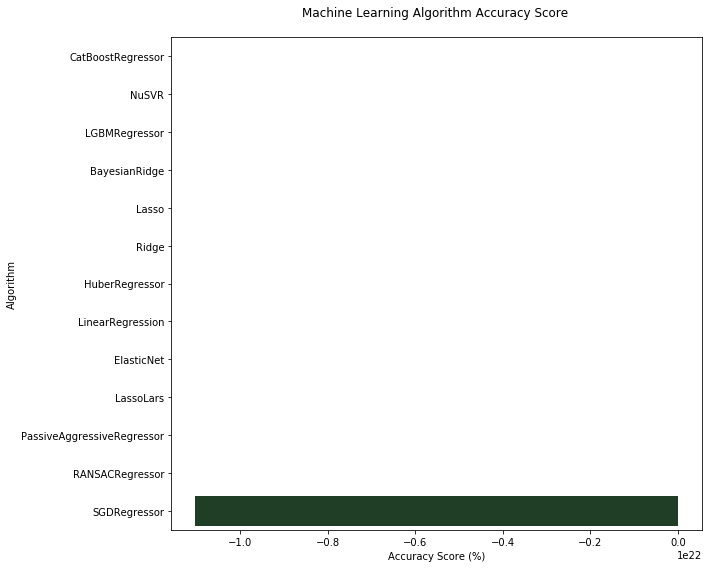

In [35]:
plt.figure(figsize=(10, 8))
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, palette=sns.cubehelix_palette(len(MLA_compare), start=2, rot=0, dark=0.2, light=.85, reverse=False))

plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')
plt.tight_layout()

#### NuSVR

In [36]:
svm = NuSVR()
svm.fit(X_train_scaled, y_train.values.flatten())
y_pred = svm.predict(X_train_scaled)

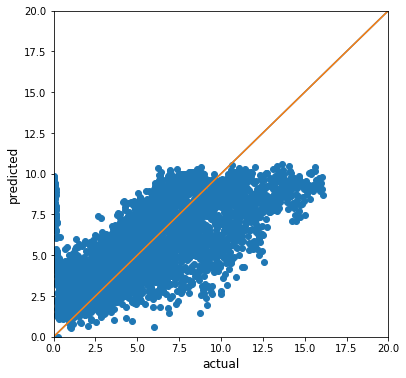

In [37]:
plt.figure(figsize=(6, 6))
plt.scatter(y_train.values.flatten(), y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [38]:
NuSVR_MAE_score = mean_absolute_error(y_train.values.flatten(), y_pred)
print('MAE: {:.5f}'.format(NuSVR_MAE_score))

MAE: 2.01275


In [39]:
submission = pd.read_csv('input/sample_submission.csv', index_col='seg_id')

In [42]:
X_test_scaled = scaler.transform(X_test)
submission['time_to_failure'] = svm.predict(X_test_scaled)
submission.to_csv('output/NuSVR_MAE{:.5f}.csv'.format(NuSVR_MAE_score))
print('output/NuSVR_MAE{:.5f}.csv'.format(NuSVR_MAE_score))

output/NuSVR_MAE2.01275.csv


### Hyperparamter optimization
[A Conceptual Explanation of Bayesian Hyperparameter Optimization for Machine Learning](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)<br/>
[Introduction: Bayesian Optimization using Hyperopt](https://github.com/WillKoehrsen/hyperparameter-optimization/blob/master/Introduction%20to%20Bayesian%20Optimization%20with%20Hyperopt.ipynb)
#### Grid search
[Parameters to tune](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc)
[Bayesian Optimization using Hyperopt](https://github.com/WillKoehrsen/hyperparameter-optimization/blob/master/Introduction%20to%20Bayesian%20Optimization%20with%20Hyperopt.ipynb)

In [ ]:
model_lgb = lgb.LGBMRegressor(learning_rate=0.05)
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=.25, train_size=.75, random_state=1)
base_results = model_selection.cross_validate(model_lgb, X_train, y_train, cv=cv_split)
model_lgb.fit(X_train, y_train)

print('BEFORE DT Parameters: ', model_lgb.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)

param_grid = {
    'boosting': ['gbdt', 'dart'],
    'lambda': [0.01, 0.1],
    'learning_rate': [0.003, 0.01, 0.03],
    'num_leaves': [10, 20]
}

tune_model = model_selection.GridSearchCV(lgb.LGBMRegressor(), param_grid=param_grid, scoring = 'neg_mean_absolute_error', cv = cv_split, verbose=1, n_jobs=4)
tune_model.fit(X_train, y_train)

print('AFTER DT Parameters: ', tune_model.best_params_)
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))

### RNN

In [ ]:
cb = [ModelCheckpoint("output/rnn.hdf5", save_best_only=True, period=3)]

model = Sequential()
model.add(CuDNNGRU(48, input_shape=(None, n_features)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.summary()

# Compile and fit model
model.compile(optimizer=adam(lr=0.0005), loss="mae")

history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=30,
                              verbose=0,
                              callbacks=cb,
                              validation_data=valid_gen,
                              validation_steps=200)

In [ ]:
import matplotlib.pyplot as plt

def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return None

perf_plot(history)

In [ ]:
submission = pd.read_csv('input/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(tqdm(submission.index)):
  #  print(i)
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    submission.time_to_failure[i] = model.predict(np.expand_dims(create_X(x), 0))

submission.head()

# Save
submission.to_csv('submission.csv')

- https://www.kaggle.com/jsaguiar/seismic-data-exploration
- https://www.kaggle.com/mjbahmani/probability-of-earthquake
- Feature selection
- RNN
- Ensembling (stacking, blending)

https://www.kaggle.com/scirpus/andrews-script-plus-a-genetic-program-model
https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction
https://www.kaggle.com/nisargpatel/time-series-garch-ts-regression
https://www.kaggle.com/zikazika/useful-new-features-and-a-optimised-model
https://www.kaggle.com/mayer79/rnn-starter-for-huge-time-series
https://www.kaggle.com/jsaguiar/seismic-data-exploration